# Получение модели, основываясь на размеченных данных

## 1. Импорт библиотек

In [47]:
# Импорт стандартных библиотек Python
import os
import random
import warnings

# Импорт библиотек для работы с данными и числовыми операциями
import pandas as pd
import numpy as np

# Импорт библиоетки для визуализации
import matplotlib.pyplot as plt

# Импорт библиотек PyTorch для создания нейронных сетей и обучения
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Импорт библиотек для машинного обучения и предобработки данных
from sklearn.model_selection import train_test_split  # для разбиения данных на обучающую и тестовую выборки
from sklearn.preprocessing import StandardScaler      # для нормализации данных
from sklearn.metrics import classification_report     # для оценки качества классификации
from imblearn.over_sampling import SMOTE              # для устранения дисбаланса классов
from sklearn.ensemble import RandomForestClassifier   # случайный лес для классификации
from xgboost import XGBClassifier                     # XGBoost для классификации
import lightgbm as lgb                                # LightGBM для классификации
from catboost import CatBoostClassifier               # CatBoost для классификации

# Импорт для сохранения и загрузки моделей
import joblib

## 2. Начальные значения

In [48]:
# Отключение предупреждений
warnings.filterwarnings("ignore")

In [49]:
# Установка устройства для PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [50]:
# Установка seed
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [51]:
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 0.0003

## 3. Подготовка данных

In [52]:
class TimeSeriesDataset(Dataset):
    """
    Класс Dataset для работы с временными рядами в PyTorch.
    Принимает данные и метки и позволяет их удобно обрабатывать
    в DataLoader для обучения моделей.
    """
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [53]:
# Функция для загрузки данных из папки
def load_data():
    data = []
    labels = []
    for folder in ['Аварийный режим', 'Нормальный режим']:
        label = 1 if folder == 'Аварийный режим' else 0
        folder_path = os.path.join(os.getcwd(), folder)
        for file in os.listdir(folder_path):
            if file.endswith('.xlsx'):
                file_path = os.path.join(folder_path, file)
                df = pd.read_excel(file_path, header=0)
                current_values = df.iloc[:, 1].values.astype(float)

                # Обрезка данных на 20% (поскольку под конец ряда можно сразу уже сказать, что неисправность точно есть и это будет поздно)
                truncate_percentage = 0.2 
                truncate_length = int(len(current_values) * truncate_percentage)
                current_values = current_values[:-truncate_length] 

                data.append(current_values)
                labels.append(label)

    return data, labels

In [54]:
data, labels = load_data()

# Определение максимальной длины временного ряда среди всех загруженных данных, что необходимо для последующего паддинга последовательностей до одной длины
max_length = max(len(series) for series in data)

data_padded = np.array([np.pad(series, (0, max_length - len(series)), 'constant') for series in data])

In [55]:
# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(data_padded, labels, test_size=0.2, random_state=42)

In [56]:
# Преобразование y_train в объект Series для получения количества классов
y_train_series = pd.Series(y_train)
class_counts = y_train_series.value_counts()
class_counts

1    404
0     51
Name: count, dtype: int64

In [57]:
# Нормализация данных
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [58]:
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [59]:
# Создание загрузчиков данных
train_dataset = TimeSeriesDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TimeSeriesDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 4. Обучение моделей

### 4.1 Одномерная свёртка без балансировки классов

In [60]:
class Conv1DModel(nn.Module):
    def __init__(self):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1) # выводит 16 каналов с фильтром 3 и паддингом 1
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1) # принимает 16 каналов, выводит 32 канала
        self.fc1 = nn.Linear(32 * (max_length // 4), 64) # # Полносвязный слой: принимает 32*(max_length // 4) входов и выводит 64
        self.fc2 = nn.Linear(64, 1)  # Один выход для бинарной классификации
        
    def forward(self, x):
        x = x.unsqueeze(1) # Добавление размерности для каналов (batch_size, channels, length)
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool1d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool1d(kernel_size=2)(x)
        x = torch.flatten(x, start_dim=1)  # Выравнивание тензора для передачи в полносвязные слои
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [61]:
model = Conv1DModel().to(device) # Создание модели и переноска её на девайс
criterion = nn.BCEWithLogitsLoss() # Определение функции ошибки для бинарной классифиакции
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE) # Оптимизатор

In [62]:
# Функция для обучения модели
def train_model(model, train_loader, val_loader, epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0 # Счётчик правильных предсказаний
        total = 0 # Общее количество образцов в обучающей выборке
        for inputs, batch_labels in train_loader:
            inputs, batch_labels = inputs.to(device), batch_labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze() # Получение предсказаний модели
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() # Накопление потерь для текущего батча
            predicted = (torch.sigmoid(outputs) > 0.5).float() # Преобразование предсказаний в бинарный формат
            total += batch_labels.size(0) 
            correct += (predicted == batch_labels).sum().item() # Подсчет правильных предсказаний
        
        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Валидация
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        # Отключение вычисления градиентов для валидации
        with torch.no_grad():
            for inputs, batch_labels in val_loader:
                inputs, batch_labels = inputs.to(device), batch_labels.to(device).float()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total_val += batch_labels.size(0)
                correct_val += (predicted == batch_labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

    # Построение графиков
    plt.figure(figsize=(12, 5))

    # График ошибок
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.title('Ошибка по эпохам')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Эпоха')
    plt.ylabel('Accuracy')
    plt.title('Accuracy по эпохам')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch [1/10], Train Loss: 1.3665, Val Loss: 0.6301, Train Acc: 0.8396, Val Acc: 0.8070
Epoch [2/10], Train Loss: 0.5879, Val Loss: 0.6205, Train Acc: 0.8352, Val Acc: 0.7982
Epoch [3/10], Train Loss: 0.3217, Val Loss: 0.6036, Train Acc: 0.8945, Val Acc: 0.7982
Epoch [4/10], Train Loss: 0.3502, Val Loss: 0.7161, Train Acc: 0.8945, Val Acc: 0.7544
Epoch [5/10], Train Loss: 0.4090, Val Loss: 0.7641, Train Acc: 0.8945, Val Acc: 0.8158
Epoch [6/10], Train Loss: 0.3505, Val Loss: 0.6912, Train Acc: 0.8945, Val Acc: 0.7807
Epoch [7/10], Train Loss: 0.3438, Val Loss: 1.4419, Train Acc: 0.9011, Val Acc: 0.7807
Epoch [8/10], Train Loss: 0.4291, Val Loss: 0.5447, Train Acc: 0.8879, Val Acc: 0.8070
Epoch [9/10], Train Loss: 0.3479, Val Loss: 0.5381, Train Acc: 0.8989, Val Acc: 0.8070
Epoch [10/10], Train Loss: 0.3359, Val Loss: 0.5927, Train Acc: 0.8923, Val Acc: 0.7719


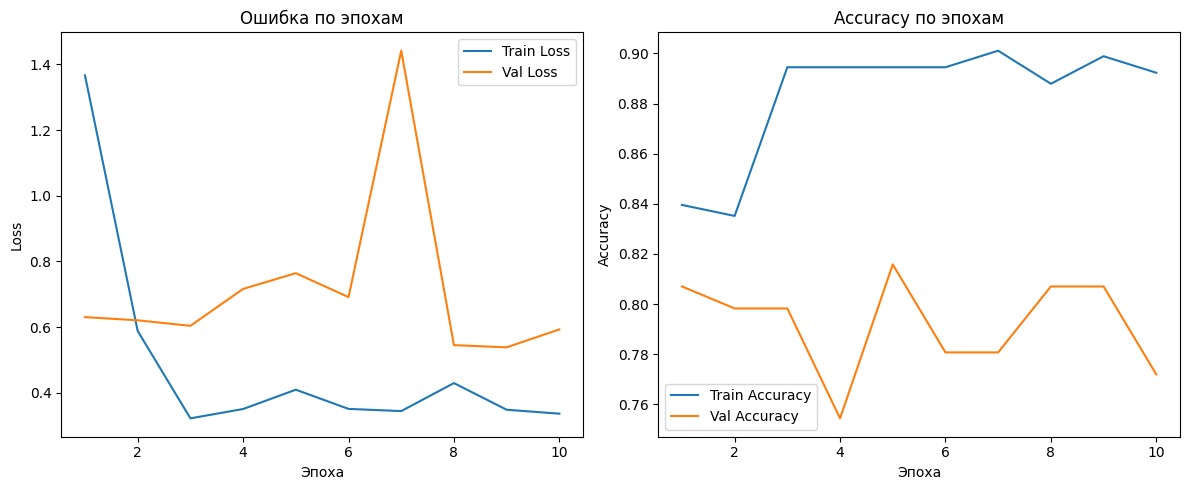

In [63]:
# Обучение модели
train_model(model, train_loader, val_loader, EPOCHS)

In [64]:
# Оценка модели
model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, batch_labels in val_loader:
        inputs, batch_labels = inputs.to(device), batch_labels.to(device)
        outputs = model(inputs).squeeze()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

In [65]:
print(classification_report(all_labels, all_predictions, target_names=['Нормальный режим (0)', 'Аварийный режим (1)']))

                      precision    recall  f1-score   support

Нормальный режим (0)       0.17      0.05      0.07        22
 Аварийный режим (1)       0.81      0.95      0.87        92

            accuracy                           0.77       114
           macro avg       0.49      0.50      0.47       114
        weighted avg       0.68      0.77      0.72       114



### 4.2 RandomForest

In [66]:
X_train_rf = X_train
y_train_rf = y_train
X_val_rf = X_val
y_val_rf = y_val

In [67]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf_model.fit(X_train_rf, y_train_rf)

RandomForestClassifier(random_state=42)

In [68]:
rf_predictions = rf_model.predict(X_val_rf)
print("RandomForest Classification Report:")
print(classification_report(y_val_rf, rf_predictions, target_names=['Нормальный режим (0)', 'Аварийный режим (1)']))

RandomForest Classification Report:
                      precision    recall  f1-score   support

Нормальный режим (0)       0.67      0.27      0.39        22
 Аварийный режим (1)       0.85      0.97      0.90        92

            accuracy                           0.83       114
           macro avg       0.76      0.62      0.65       114
        weighted avg       0.81      0.83      0.80       114



### 4.3 XGBoost

In [69]:
# Обучение XGBoost
xgb_model = XGBClassifier(eval_metric='logloss', random_state=SEED)
xgb_model.fit(X_train_rf, y_train_rf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [70]:
# Оценка XGBoost
xgb_predictions = xgb_model.predict(X_val_rf)
print("XGBoost Classification Report:")
print(classification_report(y_val_rf, xgb_predictions, target_names=['Нормальный режим (0)', 'Аварийный режим (1)']))

XGBoost Classification Report:
                      precision    recall  f1-score   support

Нормальный режим (0)       0.92      0.50      0.65        22
 Аварийный режим (1)       0.89      0.99      0.94        92

            accuracy                           0.89       114
           macro avg       0.90      0.74      0.79       114
        weighted avg       0.90      0.89      0.88       114



### 4.4 LightGBM

In [71]:
# Обучение LightGBM
lgb_model = lgb.LGBMClassifier(random_state=SEED, verbose=-1)
lgb_model.fit(X_train_rf, y_train_rf)

LGBMClassifier(random_state=42, verbose=-1)

In [72]:
X_val_rf.shape

(114, 13162)

In [73]:
# Оценка LightGBM
lgb_predictions = lgb_model.predict(X_val_rf)
print("LightGBM Classification Report:")
print(classification_report(y_val_rf, lgb_predictions, target_names=['Нормальный режим (0)', 'Аварийный режим (1)']))

LightGBM Classification Report:
                      precision    recall  f1-score   support

Нормальный режим (0)       1.00      0.59      0.74        22
 Аварийный режим (1)       0.91      1.00      0.95        92

            accuracy                           0.92       114
           macro avg       0.96      0.80      0.85       114
        weighted avg       0.93      0.92      0.91       114



### 4.5 CatBoost

In [74]:
# Установка параметров для CatBoostClassifier
catboost_model = CatBoostClassifier(random_seed=SEED, verbose=0)

In [75]:
# Обучение модели CatBoost
catboost_model.fit(X_train_rf, y_train_rf);

In [76]:
catboost_predictions = catboost_model.predict(X_val_rf)

In [77]:
print("CatBoost Classification Report:")
print(classification_report(y_val_rf, catboost_predictions, target_names=['Нормальный режим (0)', 'Аварийный режим (1)']))

CatBoost Classification Report:
                      precision    recall  f1-score   support

Нормальный режим (0)       1.00      0.50      0.67        22
 Аварийный режим (1)       0.89      1.00      0.94        92

            accuracy                           0.90       114
           macro avg       0.95      0.75      0.81       114
        weighted avg       0.91      0.90      0.89       114



### 4.6 Одномерная свёртка с балансировкой классов

In [78]:
# Балансировка классов с помощью SMOTE
smote = SMOTE(random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [79]:
y_train_resampled_series = pd.Series(y_train_resampled)
class_counts = y_train_resampled_series.value_counts()
class_counts

1    404
0    404
Name: count, dtype: int64

In [80]:
conv_scaler = StandardScaler()

In [81]:
X_train_resampled_scaled = conv_scaler.fit_transform(X_train_resampled)
X_val_scaled = conv_scaler.transform(X_val)

In [82]:
# Создание загрузчиков данных
train_dataset = TimeSeriesDataset(torch.tensor(X_train_resampled, dtype=torch.float32), torch.tensor(y_train_resampled, dtype=torch.long))
val_dataset = TimeSeriesDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [83]:
class Conv1DModel(nn.Module):
    def __init__(self):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1) # выводит 16 каналов с фильтром 3 и паддингом 1
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1) # принимает 16 каналов, выводит 32 канала
        self.fc1 = nn.Linear(32 * (max_length // 4), 64) # # Полносвязный слой: принимает 32*(max_length // 4) входов и выводит 64
        self.fc2 = nn.Linear(64, 1)  # Один выход для бинарной классификации
        
    def forward(self, x):
        x = x.unsqueeze(1) # Добавление размерности для каналов (batch_size, channels, length)
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool1d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool1d(kernel_size=2)(x)
        x = torch.flatten(x, start_dim=1)  # Выравнивание тензора для передачи в полносвязные слои
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [84]:
model = Conv1DModel().to(device) # Создание модели и переноска её на девайс
criterion = nn.BCEWithLogitsLoss() # Определение функции ошибки для бинарной классифиакции
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE) # Оптимизатор

In [85]:
# Функция для обучения модели
def train_model(model, train_loader, val_loader, epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0 # Счётчик правильных предсказаний
        total = 0 # Общее количество образцов в обучающей выборке
        for inputs, batch_labels in train_loader:
            inputs, batch_labels = inputs.to(device), batch_labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze() # Получение предсказаний модели
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() # Накопление потерь для текущего батча
            predicted = (torch.sigmoid(outputs) > 0.5).float() # Преобразование предсказаний в бинарный формат
            total += batch_labels.size(0) 
            correct += (predicted == batch_labels).sum().item() # Подсчет правильных предсказаний
        
        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Валидация
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        # Отключение вычисления градиентов для валидации
        with torch.no_grad():
            for inputs, batch_labels in val_loader:
                inputs, batch_labels = inputs.to(device), batch_labels.to(device).float()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total_val += batch_labels.size(0)
                correct_val += (predicted == batch_labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

    # Построение графиков
    plt.figure(figsize=(12, 5))

    # График ошибок
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.title('Ошибка по эпохам')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Эпоха')
    plt.ylabel('Accuracy')
    plt.title('Accuracy по эпохам')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch [1/10], Train Loss: 0.9901, Val Loss: 0.8267, Train Acc: 0.5557, Val Acc: 0.4649
Epoch [2/10], Train Loss: 0.6309, Val Loss: 0.7425, Train Acc: 0.6485, Val Acc: 0.4649
Epoch [3/10], Train Loss: 0.5941, Val Loss: 0.6150, Train Acc: 0.6683, Val Acc: 0.6140
Epoch [4/10], Train Loss: 0.5596, Val Loss: 0.6119, Train Acc: 0.7463, Val Acc: 0.6754
Epoch [5/10], Train Loss: 0.4829, Val Loss: 0.5585, Train Acc: 0.7649, Val Acc: 0.7368
Epoch [6/10], Train Loss: 0.4184, Val Loss: 0.5031, Train Acc: 0.8391, Val Acc: 0.7456
Epoch [7/10], Train Loss: 0.3741, Val Loss: 0.4806, Train Acc: 0.8490, Val Acc: 0.8070
Epoch [8/10], Train Loss: 0.3076, Val Loss: 0.5701, Train Acc: 0.8948, Val Acc: 0.7105
Epoch [9/10], Train Loss: 0.2586, Val Loss: 0.4381, Train Acc: 0.9121, Val Acc: 0.8158
Epoch [10/10], Train Loss: 0.2255, Val Loss: 0.6452, Train Acc: 0.9233, Val Acc: 0.7018


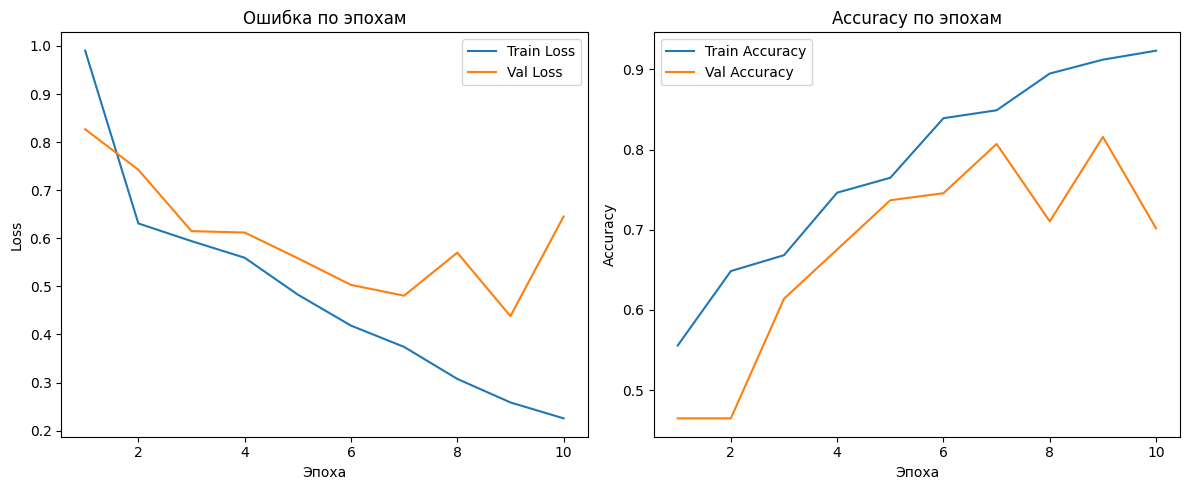

In [86]:
# Обучение модели
train_model(model, train_loader, val_loader, EPOCHS)

In [87]:
# Оценка модели
model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, batch_labels in val_loader:
        inputs, batch_labels = inputs.to(device), batch_labels.to(device)
        outputs = model(inputs).squeeze()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

In [88]:
print(classification_report(all_labels, all_predictions, target_names=['Нормальный режим (0)', 'Аварийный режим (1)']))

                      precision    recall  f1-score   support

Нормальный режим (0)       0.35      0.64      0.45        22
 Аварийный режим (1)       0.89      0.72      0.80        92

            accuracy                           0.70       114
           macro avg       0.62      0.68      0.62       114
        weighted avg       0.79      0.70      0.73       114



## 5. Сохранение модели и скэйлера

In [89]:
joblib.dump(scaler, 'scaler.pkl')
lgb_model.booster_.save_model('model.txt');

## 6. Импорт модели и проверка

In [90]:
loaded_model = lgb.Booster(model_file='model.txt')

In [91]:
# Оценка LightGBM
lgb_predictions_probs = loaded_model.predict(X_val_rf)
threshold = 0.5
lgb_predictions_binary = (lgb_predictions_probs >= threshold).astype(int)
print("LightGBM Classification Report (Загруженная модель):")
print(classification_report(y_val_rf, lgb_predictions_binary, target_names=['Нормальный режим (0)', 'Аварийный режим (1)']))

LightGBM Classification Report (Загруженная модель):
                      precision    recall  f1-score   support

Нормальный режим (0)       1.00      0.59      0.74        22
 Аварийный режим (1)       0.91      1.00      0.95        92

            accuracy                           0.92       114
           macro avg       0.96      0.80      0.85       114
        weighted avg       0.93      0.92      0.91       114

